In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [23]:
%load_ext autoreload
%autoreload 2
from pyspark.sql import SQLContext
import boto3
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sk_model import ReviewClassifier, main
import util
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Loading Data
The data is loaded from s3 bucket
1. Business dataset that describes all sorts of businesses that provide services to the general public.
2. Review dataset is a records customer reviews of differnt business in the business dataset.
3. User dataset holds the record of users who have given reviews and what businesses they reviewed.

In [4]:
f_path = "s3://chizzy/yelp_data/"
df_bus = pd.read_json(f_path+"business.json", lines=True)
df_user = pd.read_json(f_path+"user.json", lines=True)
df_rev = pd.read_json(f_path+"review.json", lines=True)

In [5]:
df_bus.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,"4855 E Warner Rd, Ste B9","{'AcceptsInsurance': True, 'ByAppointmentOnly'...",FYWN1wneV18bWNgQjJ2GNg,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,"{'Friday': '7:30-17:00', 'Tuesday': '7:30-17:0...",1,33.330690,-111.978599,Dental by Design,,85044,22,4.0,AZ
1,3101 Washington Rd,"{'BusinessParking': {'garage': False, 'street'...",He-G7vWjzVUysIKrfNbPUQ,"[Hair Stylists, Hair Salons, Men's Hair Salons...",McMurray,"{'Monday': '9:00-20:00', 'Tuesday': '9:00-20:0...",1,40.291685,-80.104900,Stephen Szabo Salon,,15317,11,3.0,PA
2,"6025 N 27th Ave, Ste 1",{},KQPW8lFf1y5BT2MxiSZ3QA,"[Departments of Motor Vehicles, Public Service...",Phoenix,{},1,33.524903,-112.115310,Western Motor Vehicle,,85017,18,1.5,AZ
3,"5000 Arizona Mills Cr, Ste 435","{'BusinessAcceptsCreditCards': True, 'Restaura...",8DShNS-LuFqpEWIp0HxijA,"[Sporting Goods, Shopping]",Tempe,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",0,33.383147,-111.964725,Sports Authority,,85282,9,3.0,AZ
4,581 Howe Ave,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",PfOCPjBrlQAnz__NXj9h_w,"[American (New), Nightlife, Bars, Sandwiches, ...",Cuyahoga Falls,"{'Monday': '11:00-1:00', 'Tuesday': '11:00-1:0...",1,41.119535,-81.475690,Brick House Tavern + Tap,,44221,116,3.5,OH


In [6]:
df_user.head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,4.67,0,0,0,0,0,0,0,0,1,...,0,[],0,"[cvVMmlU1ouS3I5fhutaryQ, nj6UZ8tdGo8YJ9lUMTVWN...",0,Johnny,8,0,oMy_rEb0UBEmMlu-zcxnoQ,2014-11-03
1,3.70,0,0,0,0,0,0,0,0,0,...,0,[],0,"[0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gp...",0,Chris,10,0,JJ-aSuM4pCFPdkfoZ34q0Q,2013-09-24
2,2.00,0,0,0,0,0,0,0,0,0,...,0,[],0,[],0,Tiffy,1,0,uUzsFQn_6cXDh6rPNGbIFA,2017-03-02
3,4.67,0,0,0,0,0,0,0,0,0,...,0,[],0,[],0,Mark,6,0,mBneaEEH5EMyxaVyqS-72A,2015-03-13
4,4.67,0,0,0,0,0,0,0,0,0,...,0,[],0,[],0,Evelyn,3,0,W5mJGs-dcDWRGEhAzUYtoA,2016-09-08


In [7]:
df_rev.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,0W4lkclzZThpx3V65bVgig,0,2016-05-28,0,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0,bv2nCi5Qv5vroFiqKGopiw
1,AEx2SYEUJmTxVVB18LlCwA,0,2016-05-28,0,vkVSCC7xljjrAI4UGfnKEQ,5,Super simple place but amazing nonetheless. It...,0,bv2nCi5Qv5vroFiqKGopiw
2,VR6GpWIda3SfvPC-lg9H3w,0,2016-05-28,0,n6QzIUObkYshz4dz2QRJTw,5,Small unassuming place that changes their menu...,0,bv2nCi5Qv5vroFiqKGopiw
3,CKC0-MOWMqoeWf6s-szl8g,0,2016-05-28,0,MV3CcKScW05u5LVfF6ok0g,5,Lester's is located in a beautiful neighborhoo...,0,bv2nCi5Qv5vroFiqKGopiw
4,ACFtxLv8pGrrxMm6EgjreA,0,2016-05-28,0,IXvOzsEMYtiJI0CARmj77Q,4,Love coming here. Yes the place always needs t...,0,bv2nCi5Qv5vroFiqKGopiw


#### Renaming some columns
There are column in with distinct features if different tables but bear the same names. For example, name apears in business table and user table, review_count is a column name in business column ad user column, cool, funny, useful are all a column name in review and user tables

In [8]:
#Renaming columns with the same names in different tables
df_bus.rename(columns={"name":"bus_name","review_count":"bus_rev_count"}, inplace=True)
df_user.rename(columns={"name":"user_name", "review_count":"user_rev_count"}, inplace=True)
df_rev.rename(columns={"cool":"cool_rev", "funny":"funny_rev", "stars":"stars_rev", "useful":"useful_rev"}, inplace=True)

In [9]:
print("Number of rows for business table: {}".format(len(df_bus)))
print("Number of rows for user table: {}".format(len(df_user)))
print("Number of rows for review table: {}".format(len(df_rev)))

Number of rows for business table: 174567
Number of rows for user table: 1326101
Number of rows for review table: 5261669


In [10]:
us_states = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS", \
            "KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY", \
            "NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]

#Extracting reviews for only US restaurants
df_bus_us = df_bus[df_bus.state.isin (us_states)]

In [11]:
#Filtering businesses that are not resturants
indx = [i for i, lst in enumerate(df_bus_us.categories)
                                if "Restaurants" in lst]

        

df_bus_us = df_bus_us.iloc[indx]

In [12]:
df_bus_us.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,bus_name,neighborhood,postal_code,bus_rev_count,stars,state
4,581 Howe Ave,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",PfOCPjBrlQAnz__NXj9h_w,"[American (New), Nightlife, Bars, Sandwiches, ...",Cuyahoga Falls,"{'Monday': '11:00-1:00', 'Tuesday': '11:00-1:0...",1,41.119535,-81.475690,Brick House Tavern + Tap,,44221,116,3.5,OH
10,737 West Pike St,"{'RestaurantsTableService': True, 'GoodForMeal...",XOSRcvtaKc_Q5H1SAzN20A,"[Breakfast & Brunch, Gluten-Free, Coffee & Tea...",Houston,{},0,40.241548,-80.212815,East Coast Coffee,,15342,3,4.5,PA
14,600 E 4th St,"{'GoodForMeal': {'dessert': False, 'latenight'...",fNMVV_ZX7CJSDWQGdOM8Nw,"[Restaurants, American (Traditional)]",Charlotte,"{'Friday': '7:00-15:00', 'Tuesday': '7:00-15:0...",1,35.221647,-80.839345,Showmars Government Center,Uptown,28202,7,3.5,NC
28,38295 Chestnut Ridge Rd,"{'GoodForMeal': {'dessert': False, 'latenight'...",Dj0S-Oe4ytRJzMGUPgYUkw,"[Soup, Salad, Sandwiches, Restaurants]",Elyria,"{'Monday': '6:30-21:00', 'Tuesday': '6:30-21:0...",1,41.343078,-82.067140,Panera Bread,,44035,4,2.0,OH
29,2429 Hwy 160 W,"{'GoodForMeal': {'dessert': False, 'latenight'...",gAy4LYpsScrj8POnCW6btQ,"[Food, American (Traditional), Coffee & Tea, R...",Fort Mill,"{'Monday': '7:00-15:00', 'Tuesday': '7:00-15:0...",0,35.047287,-80.990559,Toast Cafe,,29708,6,3.5,SC


In [13]:
print("Number of rows for business table for US states: {}".format(len(df_bus_us)))

Number of rows for business table for US states: 32472


#### Joining tables 
review table and business table will be on business_id which is a common feature between the two tables. The join will be an since only businesses with reviews and/or reviews associated with a business. Next the resullting table from the former join will be left joined with the user table on the user_id feature common to both tables

In [14]:
# Joining review and business tables
df_rev_bus = pd.merge(df_rev, df_bus_us, how='inner', on=['business_id', 'business_id'])

In [15]:
df_rev_bus.head()

,business_id,cool_rev,date,funny_rev,review_id,stars_rev,text,useful_rev,user_id,address,...,hours,is_open,latitude,longitude,bus_name,neighborhood,postal_code,bus_rev_count,stars,state
0,IXXERocY1bqGwRllcy8J2w,0,2009-08-30,0,nsThIz_-TuvgoFh0o9XJfQ,5,Visiting from SF. Checked yelp and found this...,0,_L2SZSwf7A6YSrIHy_q4cw,"831 E Johnson St, Ste 4",...,"{'Sunday': '8:00-14:00', 'Saturday': '8:00-14:...",0,43.083805,-89.376811,Sophia's Bakery & Cafe,Tenney - Lapham,53703,191,4.0,WI
1,IXXERocY1bqGwRllcy8J2w,1,2009-08-12,0,naGxxI3feEGAd2osLEPyUw,5,If you can get in the door...go! Go immediatel...,2,dt1n3wmyGvXiLIGav61teg,"831 E Johnson St, Ste 4",...,"{'Sunday': '8:00-14:00', 'Saturday': '8:00-14:...",0,43.083805,-89.376811,Sophia's Bakery & Cafe,Tenney - Lapham,53703,191,4.0,WI
2,IXXERocY1bqGwRllcy8J2w,0,2017-06-17,0,6JgLyzYpaA1CUx7QUrZJYw,3,I just came here for the pastries and they wer...,0,fs8zup-cUxKYwH1q6nlNxg,"831 E Johnson St, Ste 4",...,"{'Sunday': '8:00-14:00', 'Saturday': '8:00-14:...",0,43.083805,-89.376811,Sophia's Bakery & Cafe,Tenney - Lapham,53703,191,4.0,WI
3,IXXERocY1bqGwRllcy8J2w,0,2013-04-09,0,fdF1ZLdK-wkSx8j9QFoOIw,4,We stopped in here for a Saturday morning brea...,0,Lx5jVCom4-Y0k8duYbEhnw,"831 E Johnson St, Ste 4",...,"{'Sunday': '8:00-14:00', 'Saturday': '8:00-14:...",0,43.083805,-89.376811,Sophia's Bakery & Cafe,Tenney - Lapham,53703,191,4.0,WI
4,IXXERocY1bqGwRllcy8J2w,1,2017-01-24,0,OblJyAgrBgjhonvMHzUV3A,5,Amazing breakfast in a super cozy environment!...,2,p6RurvWCPEqR8PP4siwiVA,"831 E Johnson St, Ste 4",...,"{'Sunday': '8:00-14:00', 'Saturday': '8:00-14:...",0,43.083805,-89.376811,Sophia's Bakery & Cafe,Tenney - Lapham,53703,191,4.0,WI


In [16]:
# Joining merged review and business table with user table
df_rev_bus_user = pd.merge(df_rev_bus, df_user, how='left', on=['user_id', 'user_id'])

In [17]:
print("Number of rows for business table for concated business, user and review: {}".format(len(df_rev_bus_user)))

Number of rows for business table for concated business, user and review: 2598115


In [18]:
df_rev_bus_user.head()

,business_id,cool_rev,date,funny_rev,review_id,stars_rev,text,useful_rev,user_id,address,...,compliment_writer,cool,elite,fans,friends,funny,user_name,user_rev_count,useful,yelping_since
0,IXXERocY1bqGwRllcy8J2w,0,2009-08-30,0,nsThIz_-TuvgoFh0o9XJfQ,5,Visiting from SF. Checked yelp and found this...,0,_L2SZSwf7A6YSrIHy_q4cw,"831 E Johnson St, Ste 4",...,1,0,[],1,[],0,Joshua,47,0,2008-04-13
1,IXXERocY1bqGwRllcy8J2w,1,2009-08-12,0,naGxxI3feEGAd2osLEPyUw,5,If you can get in the door...go! Go immediatel...,2,dt1n3wmyGvXiLIGav61teg,"831 E Johnson St, Ste 4",...,9,72,"[2010, 2011, 2009]",13,"[EQAyuvxamSfn3MGMjy7dsw, UsXqCXRZwSCSw0AT7y1uB...",62,Stephanie,185,92,2008-04-01
2,IXXERocY1bqGwRllcy8J2w,0,2017-06-17,0,6JgLyzYpaA1CUx7QUrZJYw,3,I just came here for the pastries and they wer...,0,fs8zup-cUxKYwH1q6nlNxg,"831 E Johnson St, Ste 4",...,1,0,"[2016, 2017]",1,"[wd3xoNaDLib8dhQ7BxUl6g, pJyV8I6JsKG_iSzPLvb5A...",3,Tracy,45,15,2011-06-12
3,IXXERocY1bqGwRllcy8J2w,0,2013-04-09,0,fdF1ZLdK-wkSx8j9QFoOIw,4,We stopped in here for a Saturday morning brea...,0,Lx5jVCom4-Y0k8duYbEhnw,"831 E Johnson St, Ste 4",...,1,0,[],4,"[KDG4BYYAOnzErrjyIPbJJw, n6UrsZu9iMw_RZl9X6j7E...",1,Karrey,41,3,2007-12-04
4,IXXERocY1bqGwRllcy8J2w,1,2017-01-24,0,OblJyAgrBgjhonvMHzUV3A,5,Amazing breakfast in a super cozy environment!...,2,p6RurvWCPEqR8PP4siwiVA,"831 E Johnson St, Ste 4",...,26,101,"[2016, 2017, 2015]",28,"[4KYNUsdA-tPe-iKKudb0uQ, jynGTC7AOwHWFwc44glMf...",59,Emily,480,166,2012-07-29


In [19]:
df_rev_bus_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2598115 entries, 0 to 2598114
Data columns (total 44 columns):
business_id           object
cool_rev              int64
date                  datetime64[ns]
funny_rev             int64
review_id             object
stars_rev             int64
text                  object
useful_rev            int64
user_id               object
address               object
attributes            object
categories            object
city                  object
hours                 object
is_open               int64
latitude              float64
longitude             float64
bus_name              object
neighborhood          object
postal_code           object
bus_rev_count         int64
stars                 float64
state                 object
average_stars         float64
compliment_cool       int64
compliment_cute       int64
compliment_funny      int64
compliment_hot        int64
compliment_list       int64
compliment_more       int64
compliment_note  

#### Pickling table
Considering the size of the data, it is a good idea to pickle the resulting table and store it for easy access without going through the same EDA process each time. Most of the heavy lifting was done using a bigger machine on Amazon AWS.

In [20]:
# with open("../efs/df_rev_bus_user.pickle", "wb") as f:
#     pickle.dump(df_rev_bus_user, f)

In [35]:
# with open("../efs/df_rev_bus_user.pickle", "rb") as f:
#     df_loaded = pickle.load(f)

with open("../../../downloads/df_rev_bus_user.pickle", "rb") as f:
    df_loaded = pickle.load(f)

In [5]:
df_states = df_loaded[["state", "stars_rev"]].groupby("state", as_index=False).count().sort_values(by="stars_rev", ascending=False)

#### Visualizing the ratings and reviews
It seems there are more 5 and 4 star reviews than 3, 2, and 1 in the barchart below. The number of reviews given increases with ratings except for 1 star being a little more than 2 star. The histogram and box plot below shows that the review text length generally ranges between 100 to 1000 words across all 5 rating categories with exception of some outliers.

In [6]:
df_loaded['text length'] = df_loaded['text'].apply(len)

In [7]:
#Checking how many reviews in the data
df_stars=df_loaded[["text length", "stars_rev"]].groupby("stars_rev",as_index=False).count()

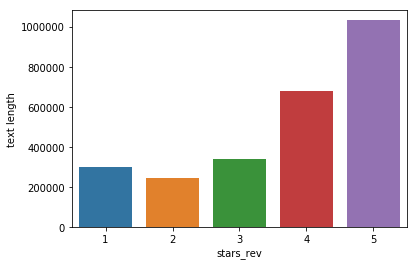

In [8]:
sns.barplot(x="stars_rev", y="text length", data=df_stars)

In [9]:
pd.unique(df_loaded["stars_rev"])

array([5, 3, 4, 1, 2])

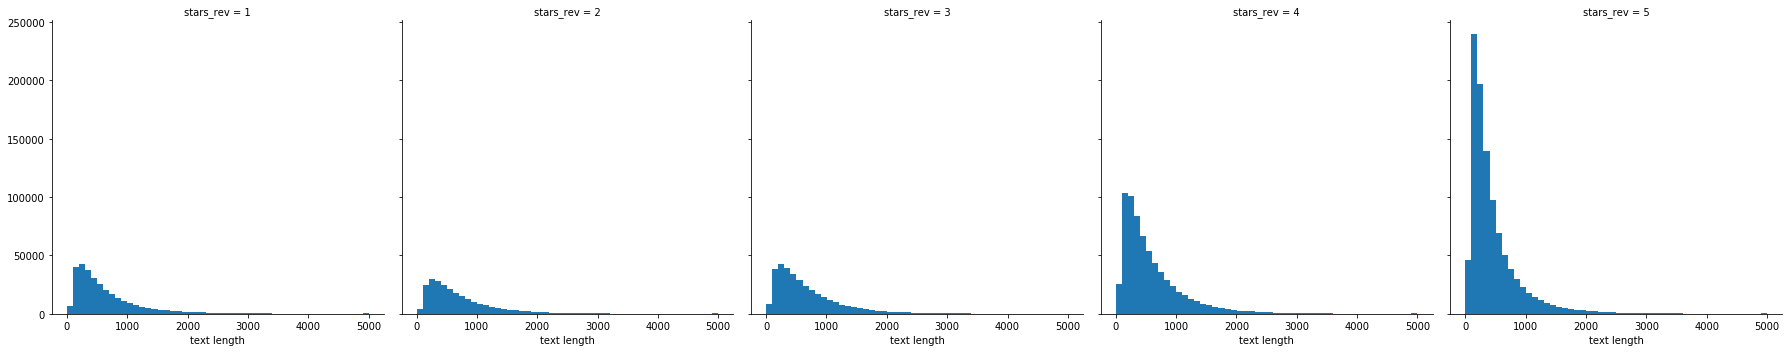

In [10]:
g = sns.FacetGrid(data=df_loaded, col='stars_rev', size=5)
g.map(plt.hist, 'text length', bins=50)

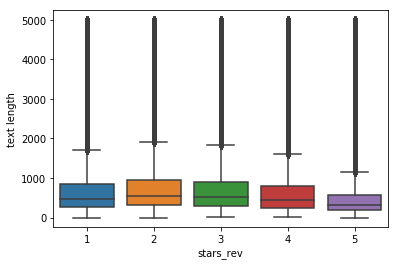

In [11]:
sns.boxplot(x='stars_rev', y='text length', data=df_loaded)

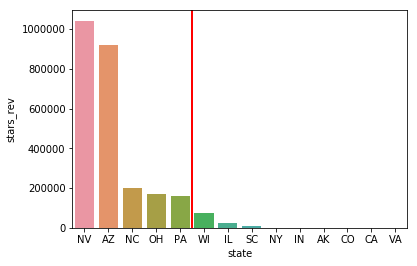

In [12]:
sns.barplot(x="state", y="stars_rev", data=df_states)
_=plt.axvline(x=4.5, linewidth=2, color="r")

In [14]:
num=sum(df_states["stars_rev"].iloc[:5])
den=sum(df_states["stars_rev"])
print("Percent of data accounted by states before the line: {}%". format(round(num/den * 100, 2)))

Percent of data accounted by states before the line: 95.91%


The plot above shows that most of the review data available are from less than half of the states. Only the data for the states before the vertical line in the plot will be used to build the model as they account for 95.91% of the data and the rest for validation.

In [5]:
#Splitting the data
df_build = df_loaded[df_loaded["state"].isin(["NV", "AZ", "NC", "OH", "PA"])]
df_test = df_loaded[df_loaded["state"].isin(["NV", "AZ", "NC", "OH", "PA"]) == False]

In [16]:
# with open("../efs/df_test.pickle", "wb") as f:
#     pickle.dump(df_test, f)

#### Preping Data for 1-star 5-star classification
The data will tokenized, lemmatized and stripped of stopwords and return as an array of documents. Next, the documents are striped of symbols and words containing numbers. This process allows for only important words that describe the information in that document. 

In [14]:
# df = df_loaded[["text", "stars_rev"]][df_loaded["state"]=="WI"]
# df = df[df.stars_rev.isin([1,5])]
df = df_build[["text", "stars_rev"]]
df = df[df.stars_rev.isin([1,5])]
df.head()

,text,stars_rev
191,We always go to the chevo's in chandler which ...,1
192,Great grilled chicken burrito which believe it...,5
193,Everything I've had so far has been great. Not...,5
195,Can't describe how bad this place is...was hop...,1
196,Bomb.com\n\nWas craving some good Mexican food...,5


In [18]:
y = df["stars_rev"].values
corpus = df["text"].values

In [19]:
print("Number of words reviews in corpus: {}".format(len(corpus)))

Number of words reviews in corpus: 1285808


In [22]:
#View a document before cleaning
corpus[0]

"We always go to the chevo's in chandler which is delicious, the one in ahwatukee is different for some reason.  Ordered the chicken rolled tacos today there was a tiny lil piece of chicken in each one, so basically I had 3 rolled deep fried tortillas yuck! :( No flavor what so ever.  Also ordered carne asada taco the meat tasted old like it was cooked earlier and just thrown on the grill to get warm.  Very dissapointed!!"

In [23]:
cleaned = util.clean_stem(corpus)

In [24]:
#View a document after cleaning
cleaned[0]

"always go chevo's chandler delicious one ahwatukee different reason ordered chicken rolled taco today tiny lil piece chicken one basically rolled deep fried tortilla yuck flavor ever also ordered carne asada taco meat tasted old like cooked earlier thrown grill get warm dissapointed"

In [25]:
print("Number of words before cleaning, and removing stopwords: {}".format(len("".join(corpus).split())))
print("Number of words after cleaning, and removing stopwords: {}".format(len("".join(cleaned).split())))

Number of words before cleaning, and removing stopwords: 120688125
Number of words after cleaning, and removing stopwords: 60817433


In [26]:
X_train, X_test, y_train, y_test = train_test_split(cleaned, y, test_size=0.25, random_state=1)

### LogisticRegression Linear model
The ReviewClassifier class performs a vectorization on the corpus of cleaned words and builds the feature matrix using TfIDF(Term frequency inverse transform frequency) which is fed to a Logistic Regression model for classification.

In [27]:
model15 = ReviewClassifier()
model15.fit(X_train, y_train)
y_pred = model15.predict(X_test)

In [28]:
#Estimating metrics
matrix, recall, precision, accuracy = model15.metrics_eval(X_test, y_test)

In [29]:
#confusion matrix
matrix

array([[246523,   3705],
       [  2515,  68709]])

In [30]:
print("Recall: {}%".format(round(recall*100, 2)))
print("Precision: {}%".format(round(precision*100, 2)))
print("Accuracy: {}%".format(round(accuracy*100, 2)))

Recall: 98.99%
Precision: 98.52%
Accuracy: 98.07%


In [16]:
# Positive and negative sentiments
pos_terms, neg_terms = model15.feature_importance(40)

In [32]:
pos_terms

[('delicious', 21.545791791843364),
 ('amazing', 19.670088894739212),
 ('great', 17.341812613990015),
 ('awesome', 16.066073122631803),
 ('best', 15.799050863989965),
 ('excellent', 15.782685134741055),
 ('perfect', 14.34991597611837),
 ('fantastic', 13.345065296405451),
 ('love', 12.316899575710048),
 ('favorite', 11.75256798683862),
 ('perfectly', 10.752482826416426),
 ('loved', 10.615953556643225),
 ('outstanding', 10.193136249755657),
 ('wonderful', 9.941801726833678),
 ('yummy', 9.620769890531777),
 ('perfection', 9.391673367911364),
 ('friendly', 9.33415481635652),
 ('incredible', 9.024244237766641),
 ('definitely', 8.7704367386723),
 ('notch', 8.499168501919296),
 ('die', 7.823317516343465),
 ('phenomenal', 7.7869348216348815),
 ('beat', 7.764767831512102),
 ('bomb', 7.646431377163423),
 ('delish', 7.514748600418767),
 ('glad', 7.495890092717456),
 ('highly', 7.38080139357425),
 ('reasonably', 7.296161201159332),
 ('superb', 7.1803480334012635),
 ('enjoyed', 7.167844076417469),


In [17]:
neg_terms

[('worst', -18.632991293801073),
 ('horrible', -15.411915515187022),
 ('terrible', -13.823528478977607),
 ('bland', -12.563329547852629),
 ('awful', -12.443873899302082),
 ('mediocre', -12.288587981669574),
 ('disappointing', -11.876978105735859),
 ('rude', -11.536995869589457),
 ('poisoning', -10.941568614432123),
 ('disgusting', -10.181109854137999),
 ('poor', -10.155878087034957),
 ('tasteless', -10.05577823517732),
 ('worse', -9.55378041759944),
 ('dry', -9.228186285048212),
 ('gross', -9.149051948362953),
 ('waste', -9.14478216352569),
 ('overpriced', -9.082138286215311),
 ('disappointment', -9.024991452455488),
 ('flavorless', -8.471733456821335),
 ('inedible', -8.280089527339477),
 ('zero', -7.722555743435734),
 ('stale', -7.608663219309208),
 ('slow', -7.395978896685809),
 ('charged', -7.36738655451742),
 ('sick', -7.180401627754122),
 ('unfortunately', -7.163027507017637),
 ('suck', -7.0723075647015765),
 ('nasty', -6.995871909583275),
 ('cold', -6.973533706573698),
 ('lacked'

In [34]:
with open("../efs/models/model15.pickle", "wb") as f:
    pickle.dump(model15, f)

In [15]:
with open("../efs/models/model15.pickle", "rb") as f:
    model15 = pickle.load(f)

### Testing

#### Building model combination
The above results gave a good contrast between a 1-star rating and a 5-star rating, and that is expected because a 1-star rating can be seen as an opposite of a 5-star rating and the the words associated to these ratings have clear opposite connotations. It will be interesting to see how customer experience will vary if as the gap between positive and negative experience closes in. Models for 5-2, 5-3, 5-4, 1-2, 1-3 and 1-4 star ratings will be built to see the effect.

In [9]:
#4-star and 5-star ratings
model45 = main(df_build, 0, 0.25, 4, 5, state=None)

Number of reviews: 1642754 

Confusion matrix
[[207131  63125]
 [ 42148  98285]] 

Recall: 83.09%
Precision: 76.64%
Accuracy: 74.37%


In [10]:
# with open("../efs/models/model45.pickle", "wb") as f:
#     pickle.dump(model45, f)

In [4]:
# with open("../efs/models/model45.pickle", "rb") as f:
#     model45 = pickle.load(f)

with open("../break_week/models/model45.pickle", "rb") as f:
    model45 = pickle.load(f)

In [5]:
# with open("../efs/df_test.pickle", "rb") as f:
#     df_test = pickle.load(f)

with open("../break_week/df_test.pickle", "rb") as f:
    df_test = pickle.load(f)

Restaurant Name: The Old Fashioned 

Size of corpus: 1139 

Recall: 0.78%
Precision: 0.66%
Accuracy: 67.34%

 [('Food', {'overall': 3, 'decent': 7, 'slow': 2, 'reason': 3, 'okay': 1, 'ok': 1, 'bland': 1, 'lacking': 1, 'lacked': 1}), ('Service', {'ok': 2, 'overall': 5, 'spotty': 1, 'meh': 1, 'decent': 6, 'slow': 2}), ('Location', {'ok': 1, 'overall': 2, 'decent': 1, 'reason': 3}), ('Drink', {'decent': 1, 'okay': 1}), ('Cost', {'decent': 5})] 


 [('Food', {'best': 111, 'amazing': 35, 'awesome': 18, 'heaven': 3, 'favorite': 16, 'phenomenal': 3, 'omg': 3, 'unbelievable': 1, 'incredible': 2, 'wow': 2, 'perfection': 1}), ('Service', {'thank': 1, 'awesome': 9, 'amazing': 10, 'best': 6, 'perfection': 1, 'incredible': 3, 'favorite': 1, 'phenomenal': 2}), ('Location', {'favorite': 41, 'best': 23, 'highly': 30, 'awesome': 7, 'phenomenal': 1, 'wow': 1, 'omg': 1, 'amazing': 6}), ('Drink', {'awesome': 9, 'amazing': 8, 'heaven': 2, 'favorite': 8, 'incredible': 3, 'best': 5, 'phenomenal': 1}), ('Cost

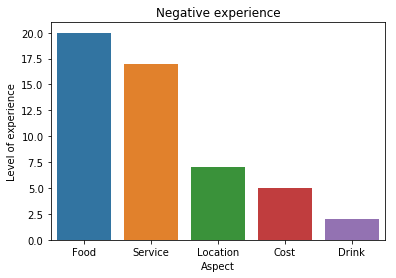

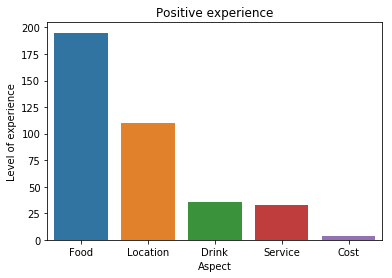

In [24]:
util.vary_ratings(model45, df_test, 4, 5, indx=10, bus_name="The Old Fashioned")

In [12]:
#3-star and 5-star ratings
model35 = main(df_build, 0, 0.25, 3, 5, state=None)

Number of reviews: 1317891 

Confusion matrix
[[238521  17604]
 [ 10082  63266]] 

Recall: 95.94%
Precision: 93.13%
Accuracy: 91.6%


In [13]:
with open("../efs/models/model35.pickle", "wb") as f:
    pickle.dump(model35, f)

In [9]:
# with open("../efs/models/model35.pickle", "rb") as f:
#     model35 = pickle.load(f)
    
with open("../break_week/models/model35.pickle", "rb") as f:
    model35 = pickle.load(f)

Restaurant Name: The Old Fashioned 

Size of corpus: 794 

Recall: 0.95%
Precision: 0.93%
Accuracy: 91.18%

 [('Food', {'decent': 7, 'mediocre': 2, 'average': 2, 'okay': 3, 'lacking': 1, 'unfortunately': 2, 'ok': 1, 'bland': 1, 'lacked': 2}), ('Service', {'ok': 2, 'alright': 1, 'mediocre': 1, 'okay': 2, 'average': 1, 'worst': 1, 'unfortunately': 1, 'decent': 1}), ('Drink', {'bland': 1, 'decent': 1, 'meh': 1, 'average': 1}), ('Location', {'decent': 4, 'unfortunately': 1, 'average': 1}), ('Cost', {'decent': 1})] 


 [('Food', {'great': 86, 'best': 75, 'excellent': 19, 'amazing': 21, 'wonderful': 4, 'awesome': 14, 'delicious': 24, 'fantastic': 5, 'favorite': 11, 'perfectly': 8, 'perfect': 6, 'incredible': 1, 'perfection': 1}), ('Drink', {'excellent': 11, 'great': 40, 'favorite': 4, 'best': 5, 'delicious': 5, 'perfect': 2, 'incredible': 2, 'wonderful': 2, 'amazing': 5, 'awesome': 4, 'fantastic': 4, 'gem': 1, 'perfectly': 1}), ('Service', {'great': 55, 'perfect': 2, 'delicious': 8, 'excelle

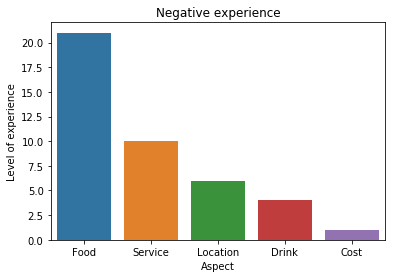

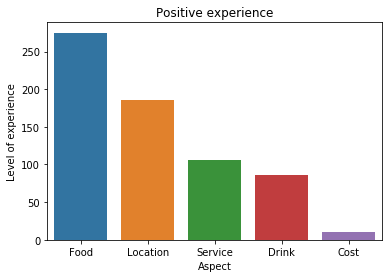

In [25]:
util.vary_ratings(model35, df_test, 3, 5, indx=33, bus_name="The Old Fashioned")

In [15]:
#2-star and 5-star ratings
model25 = main(df_build, 0, 0.25, 2, 5, state=None)

Number of reviews: 1230500 

Confusion matrix
[[244876   6519]
 [  3636  52594]] 

Recall: 98.54%
Precision: 97.41%
Accuracy: 96.7%


In [16]:
with open("../efs/models/model25.pickle", "wb") as f:
    pickle.dump(model25, f)

In [12]:
# with open("../efs/models/model25.pickle", "rb") as f:
#     model25 = pickle.load(f)
    
with open("../break_week/models/model25.pickle", "rb") as f:
    model25 = pickle.load(f)

Restaurant Name: The Old Fashioned 

Size of corpus: 669 

Recall: 0.99%
Precision: 0.99%
Accuracy: 97.91%

 [('Food', {'horrible': 1, 'worst': 1, 'terrible': 2, 'ok': 3, 'mediocre': 5, 'bland': 1, 'disappointing': 1, 'overpriced': 1, 'okay': 1}), ('Service', {'okay': 2, 'terrible': 4, 'mediocre': 3, 'bland': 3, 'ok': 1, 'awful': 1, 'disappointing': 1}), ('Location', {'mediocre': 1, 'ok': 1, 'okay': 2}), ('Drink', {'terrible': 1}), ('Cost', {})] 


 [('Food', {'love': 25, 'best': 69, 'perfect': 6, 'great': 78, 'delicious': 19, 'amazing': 18, 'favorite': 11, 'excellent': 17, 'wonderful': 4, 'awesome': 13, 'loved': 4, 'incredible': 1, 'fantastic': 4, 'perfection': 1, 'perfectly': 6}), ('Service', {'great': 56, 'perfect': 2, 'delicious': 6, 'excellent': 10, 'awesome': 6, 'amazing': 10, 'fantastic': 4, 'best': 3, 'perfection': 1, 'incredible': 2, 'loved': 1, 'perfectly': 2, 'love': 1}), ('Drink', {'excellent': 8, 'great': 31, 'favorite': 4, 'best': 4, 'delicious': 5, 'perfect': 2, 'love': 

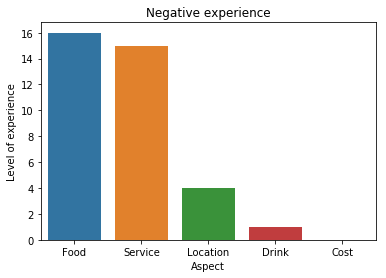

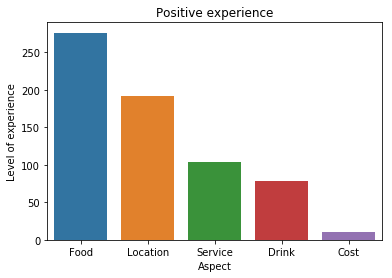

In [26]:
util.vary_ratings(model25, df_test, 2, 5, indx=33, bus_name="The Old Fashioned")

In [18]:
#1-star and 2-star ratings
model12 = main(df_build, 0, 0.25, 1, 2, state=None)

Number of reviews: 526310 

Confusion matrix
[[41204 15074]
 [17553 57747]] 

Recall: 70.13%
Precision: 73.22%
Accuracy: 75.2%


In [19]:
with open("../efs/models/model12.pickle", "wb") as f:
    pickle.dump(model12, f)

In [14]:
# with open("../efs/models/model12.pickle", "rb") as f:
#     model12 = pickle.load(f)
    
with open("../break_week/models/model12.pickle", "rb") as f:
    model12 = pickle.load(f)

Restaurant Name: The Old Fashioned 

Size of corpus: 104 

Recall: 0.88%
Precision: 0.9%
Accuracy: 82.69%

 [('Service', {'terrible': 4, 'awful': 1, 'waste': 2, 'horrible': 1}), ('Food', {'horrible': 1, 'worst': 1, 'terrible': 3}), ('Drink', {'terrible': 1}), ('Location', {}), ('Cost', {})] 


 [('Service', {'great': 7, 'average': 1, 'okay': 2, 'excellent': 1, 'good': 6, 'ok': 1, 'star': 1}), ('Food', {'great': 6, 'good': 14, 'average': 1, 'ok': 3, 'alright': 1}), ('Location', {'good': 2, 'nice': 4, 'ok': 1, 'great': 3, 'okay': 2}), ('Drink', {'good': 4, 'great': 2, 'decent': 2}), ('Cost', {})] 



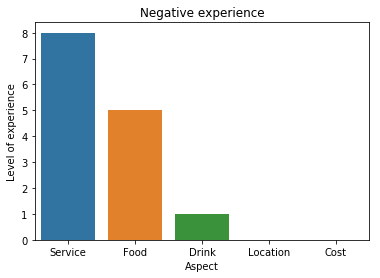

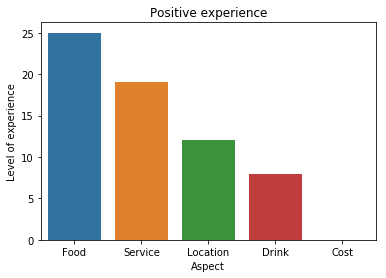

In [27]:
util.vary_ratings(model12, df_test, 1, 2, indx=33, bus_name="The Old Fashioned")

In [21]:
#1-star and 3-star ratings
model13 = main(df_build, 0, 0.25, 1, 3, state=None)

Number of reviews: 613701 

Confusion matrix
[[72090  8566]
 [ 8477 64293]] 

Recall: 89.48%
Precision: 89.38%
Accuracy: 88.89%


In [22]:
with open("../efs/models/model13.pickle", "wb") as f:
    pickle.dump(model13, f)

In [16]:
# with open("../efs/models/model13.pickle", "rb") as f:
#     model13 = pickle.load(f)
    
with open("../break_week/models/model13.pickle", "rb") as f:
    model13 = pickle.load(f)

Restaurant Name: The Old Fashioned 

Size of corpus: 229 

Recall: 0.92%
Precision: 0.97%
Accuracy: 89.96%

 [('Service', {'disappointment': 1, 'horrible': 1, 'awful': 1, 'worst': 1}), ('Food', {'disappointment': 1, 'awful': 1, 'terrible': 1}), ('Location', {'poor': 1}), ('Drink', {'disappointment': 1}), ('Cost', {})] 


 [('Food', {'bit': 2, 'decent': 6, 'enjoyed': 5, 'good': 35, 'great': 14, 'excellent': 2, 'solid': 1, 'tasty': 3, 'loved': 3, 'amazing': 2, 'delicious': 5, 'awesome': 1, 'fantastic': 1}), ('Service', {'good': 13, 'awesome': 1, 'great': 6, 'delish': 1, 'solid': 1, 'delicious': 2, 'tasty': 1, 'bit': 1}), ('Location', {'great': 18, 'decent': 4, 'awesome': 1, 'enjoyed': 1, 'solid': 3, 'good': 9, 'excellent': 2}), ('Drink', {'great': 12, 'good': 14, 'excellent': 3, 'bit': 1, 'amazing': 1, 'decent': 1, 'enjoyed': 2}), ('Cost', {'good': 2})] 



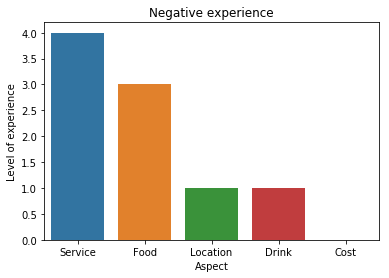

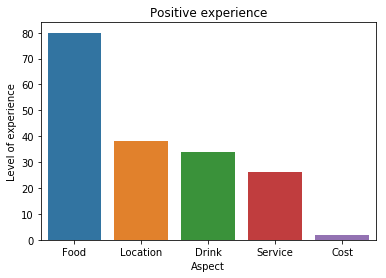

In [35]:
util.vary_ratings(model13, df_test, 1, 3, indx=33, bus_name="The Old Fashioned")

In [6]:
#1-star and 4-star ratings
model14 = main(df_build, 0, 0.25, 1, 4, state=None)

Number of reviews: 938564 

Confusion matrix
[[158404   4740]
 [  3708  67789]] 

Recall: 97.71%
Precision: 97.09%
Accuracy: 96.4%


In [7]:
with open("../efs/models/model14.pickle", "wb") as f:
    pickle.dump(model14, f)

In [28]:
# with open("../efs/models/model14.pickle", "rb") as f:
#     model14 = pickle.load(f)

with open("../break_week/models/model14.pickle", "rb") as f:
    model14 = pickle.load(f)

Restaurant Name: The Old Fashioned 

Size of corpus: 574 

Recall: 0.98%
Precision: 0.99%
Accuracy: 97.91%

 [('Food', {'disappointing': 2, 'worst': 2, 'mediocre': 2, 'poor': 1, 'terrible': 1, 'bland': 2}), ('Service', {'horrible': 2, 'disappointing': 1, 'poor': 1}), ('Location', {}), ('Drink', {}), ('Cost', {})] 


 [('Food', {'great': 62, 'good': 82, 'amazing': 16, 'enjoyed': 10, 'tasty': 9, 'delicious': 20, 'love': 16, 'awesome': 5, 'loved': 6, 'excellent': 6, 'yummy': 5, 'perfect': 1, 'perfectly': 7, 'fantastic': 2}), ('Location', {'great': 73, 'love': 9, 'good': 18, 'awesome': 3, 'loved': 6, 'delicious': 1, 'excellent': 4, 'perfect': 3, 'fantastic': 3, 'amazing': 2}), ('Drink', {'good': 25, 'excellent': 8, 'great': 26, 'delicious': 7, 'amazing': 4, 'awesome': 5, 'fantastic': 1, 'love': 4, 'loved': 1}), ('Service', {'great': 30, 'good': 30, 'excellent': 3, 'loved': 2, 'delicious': 5, 'awesome': 3, 'tasty': 1, 'love': 1}), ('Cost', {'good': 7, 'delicious': 1, 'great': 3})] 



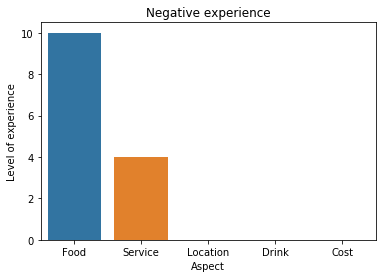

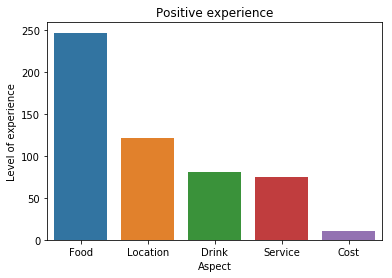

In [29]:
util.vary_ratings(model14, df_test, 1, 4, indx=13, bus_name="The Old Fashioned")

In [64]:
#1-star and 5-star ratings
model15 = main(df_build, 0, 0.25, 1, 5, state=None)

Number of reviews: 1285808 

Confusion matrix
[[246215   3593]
 [  2530  69114]] 

Recall: 98.98%
Precision: 98.56%
Accuracy: 98.1%


In [65]:
with open("../efs/models/model15.pickle", "wb") as f:
    pickle.dump(model15, f)

In [30]:
# with open("../efs/models/model15.pickle", "rb") as f:
#     model15 = pickle.load(f)

with open("../break_week/models/model15.pickle", "rb") as f:
    model15 = pickle.load(f)

Restaurant Name: The Old Fashioned 

Size of corpus: 611 

Recall: 0.99%
Precision: 1.0%
Accuracy: 99.18%

 [('Food', {'disappointing': 1, 'terrible': 1, 'bland': 1}), ('Service', {'mediocre': 1, 'rude': 1, 'horrible': 1}), ('Location', {}), ('Drink', {}), ('Cost', {})] 


 [('Food', {'love': 22, 'best': 68, 'perfect': 6, 'delicious': 19, 'amazing': 18, 'great': 74, 'favorite': 10, 'excellent': 17, 'wonderful': 4, 'awesome': 13, 'loved': 4, 'fantastic': 4, 'yummy': 1, 'outstanding': 4, 'perfectly': 6}), ('Service', {'great': 49, 'perfect': 2, 'outstanding': 1, 'delicious': 6, 'excellent': 9, 'awesome': 6, 'amazing': 10, 'fantastic': 4, 'yummy': 1, 'best': 3, 'loved': 1, 'perfectly': 2, 'love': 1}), ('Location', {'great': 66, 'amazing': 4, 'awesome': 4, 'love': 32, 'loved': 9, 'wonderful': 4, 'delicious': 3, 'fantastic': 4, 'favorite': 29, 'best': 18, 'excellent': 2, 'perfect': 10}), ('Drink', {'excellent': 8, 'great': 29, 'favorite': 4, 'best': 4, 'delicious': 5, 'perfect': 2, 'love': 

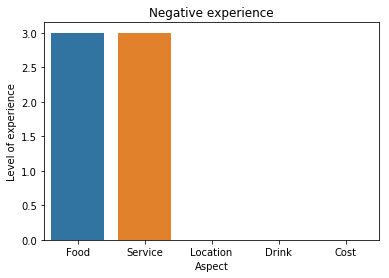

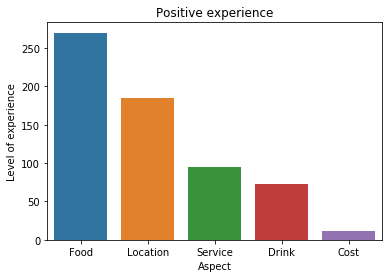

In [31]:
util.vary_ratings(model15, df_test, 1, 5, indx=20, bus_name="The Old Fashioned")

### Models Accuracy
The plot below shows how the accuracy of the models change with each combination in star ratings. Accuracy for 1-star vs all increases as the gap in rating widens towards 5-star rating as well as 5-star vs all accuracy inceasing as gap between ratings widens towards 1-star.

In [32]:
acc_1_vs_all = [[2,75.2], [3,88.89], [4,96.4], [5,98.1]]
acc_5_vs_all = [[1,98.1],[2,96.7], [3,91.6], [4,72.95]]
star_1 = pd.DataFrame(acc_1_vs_all, columns=["Ratings", "Accuracy"])
star_5 = pd.DataFrame(acc_5_vs_all, columns=["Ratings", "Accuracy"])

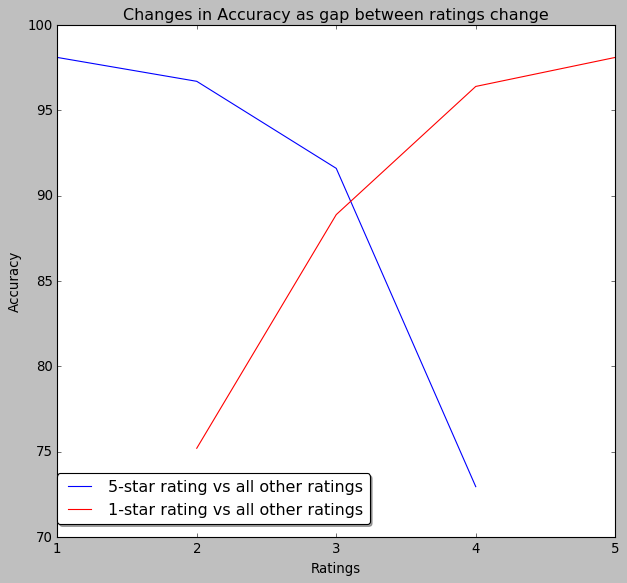

In [40]:
plt.style.use('seaborn-colorblind')
plt.figure(figsize=(9,8))
plt.xticks([1,2,3,4,5])
plt.plot(star_5["Ratings"], star_5["Accuracy"], label="5-star rating vs all other ratings", color="b")
plt.plot(star_1["Ratings"], star_1["Accuracy"], label="1-star rating vs all other ratings",color="r")
plt.xlabel("Ratings")
plt.ylabel("Accuracy")
plt.title("Changes in Accuracy as gap between ratings change")
plt.legend(loc='upper center', bbox_to_anchor=(0.28, 0.14),
          fancybox=True, shadow=True)